**Part 1**. In this analysis, we will explore a dataset from a health study designed to understand factors influencing individual stress levels. You can access the data set at

https://richardson.byu.edu/220/stress.csv

The dataset includes several predictors: Age, Occupation, Physical Activity Level, Sleep Quality, Daily Screen Time, Social Interactions, Financial Stress, and Diet Quality. The target variable is the Stress Level Score. Our objectives are to explore the data, fit various models, and interpret our findings.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from statsmodels.sandbox.regression.predstd import wls_prediction_std
import scipy.stats as stats

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score


In [2]:
df = pd.read_csv('https://richardson.byu.edu/220/stress.csv')
print(df.head())
print("---------------\n")
print(df.describe())
print("---------------\n")
print(df.isnull().sum())
print("---------------\n")

   age    occupation physical_activity  sleep_quality  daily_screen_time  \
0   65  Professional         Sedentary              9                  7   
1   32       Retired         Sedentary              9                  3   
2   37  Professional         Sedentary              9                  7   
3   48  Professional             Light             10                  4   
4   65    Unemployed          Moderate              9                  3   

   social_interactions  financial_stress diet_quality  stress_level_score  
0                    2                 4         Good                 3.2  
1                    1                 3    Excellent                 0.8  
2                    2                 5         Good                 5.3  
3                    3                 3         Good                 3.4  
4                    1                 9      Average                 0.8  
---------------

               age  sleep_quality  daily_screen_time  social_interacti

Problem 1. Perform an exploratory data analysis. Plot the target variable as well as each other continuous variable. Does it seem like any need to be transformed by taking the log of the data?


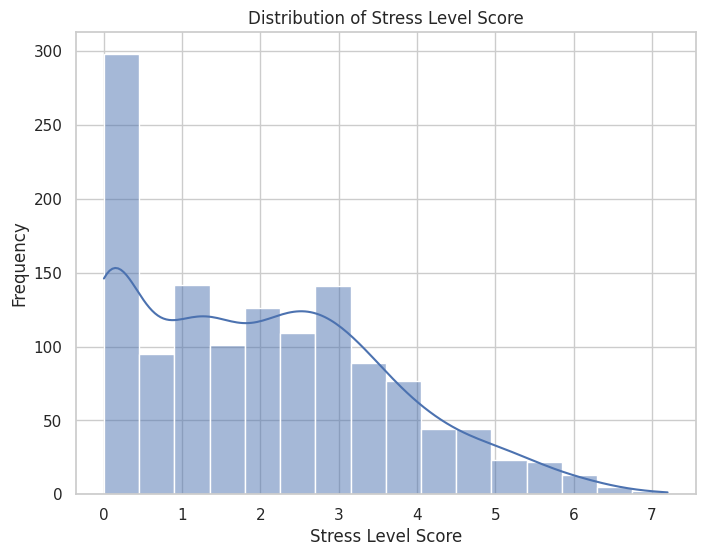

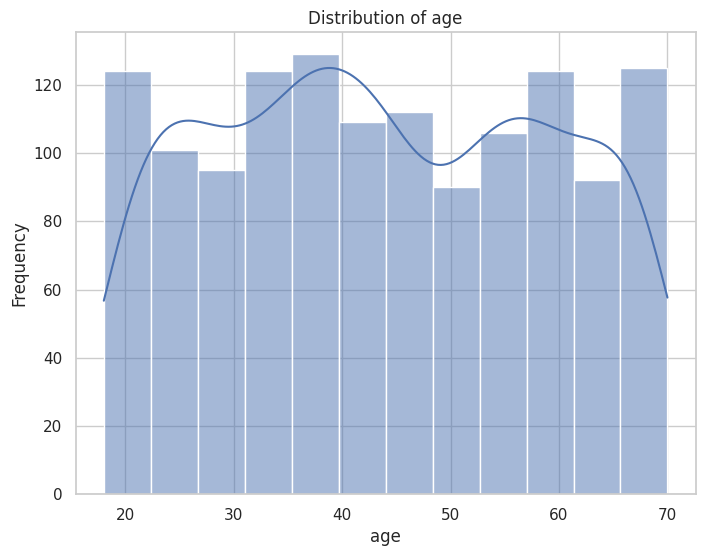

Requires Log Transformation


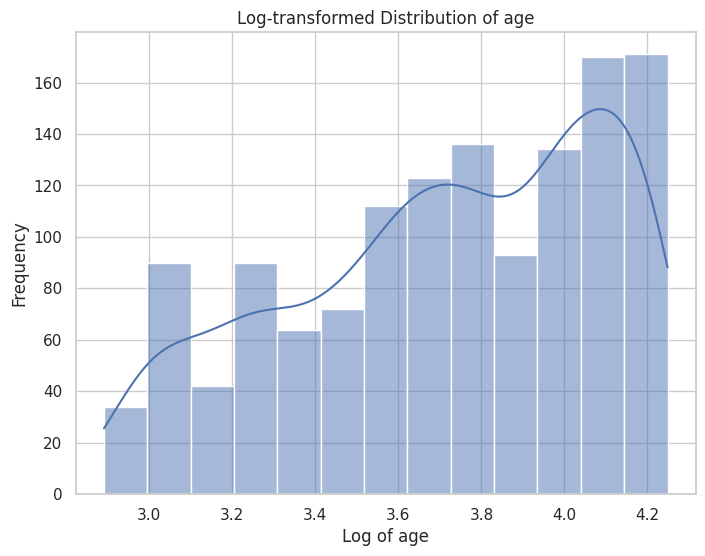

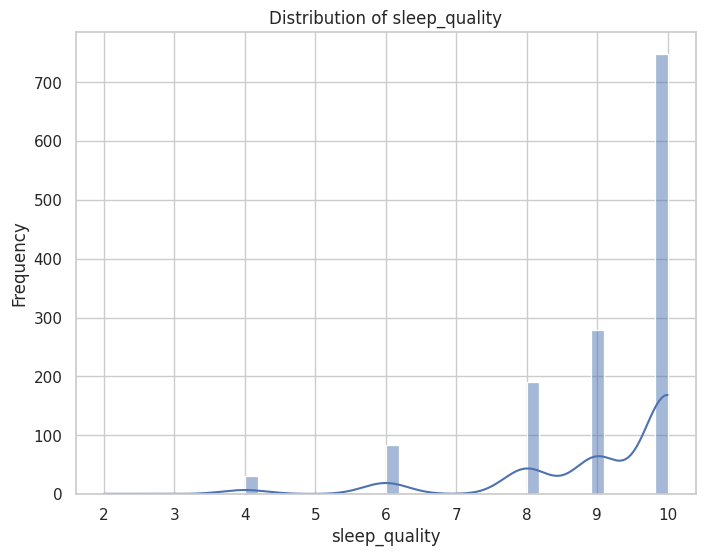

Requires Log Transformation


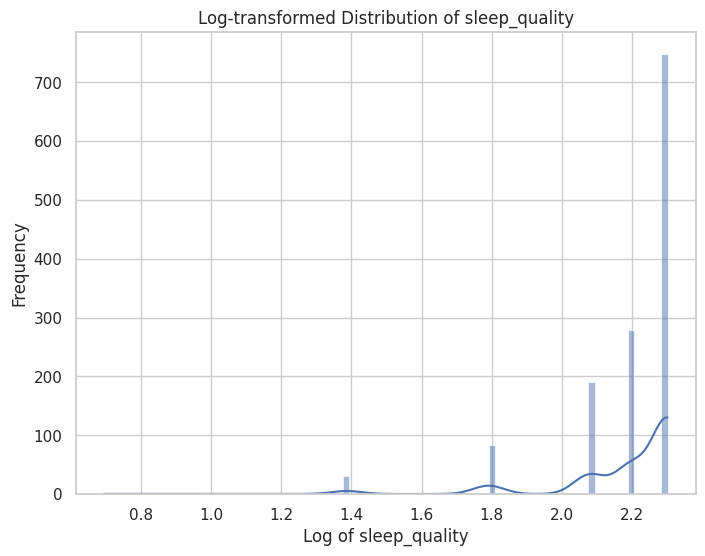

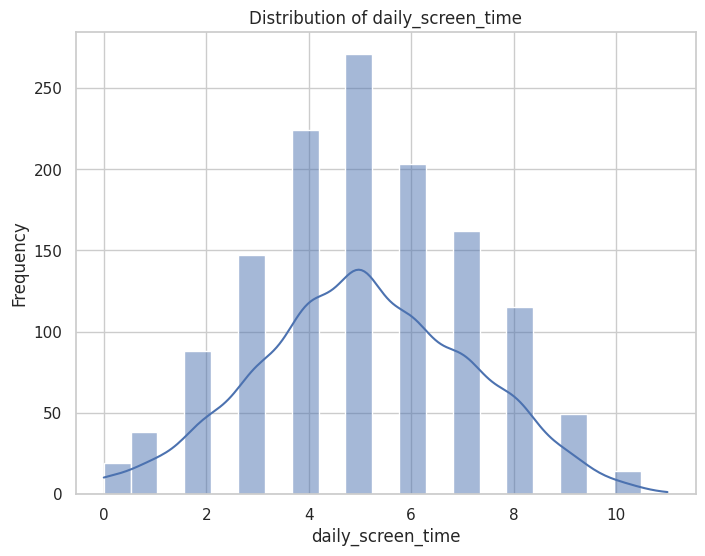

No Log Transformation


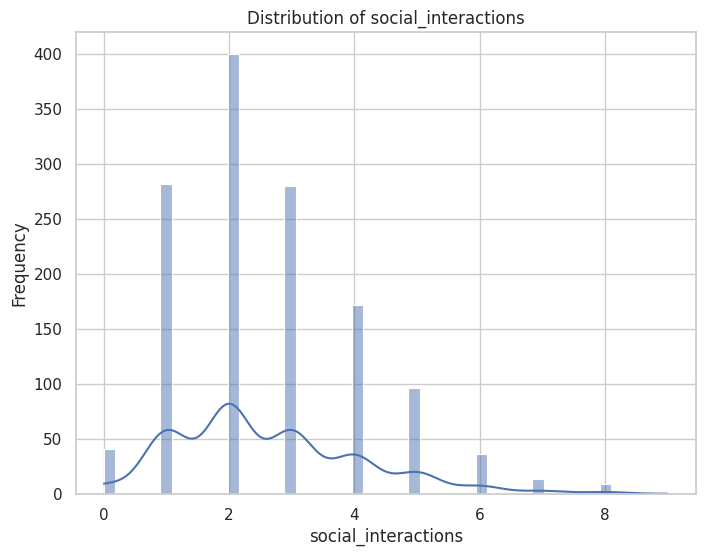

No Log Transformation


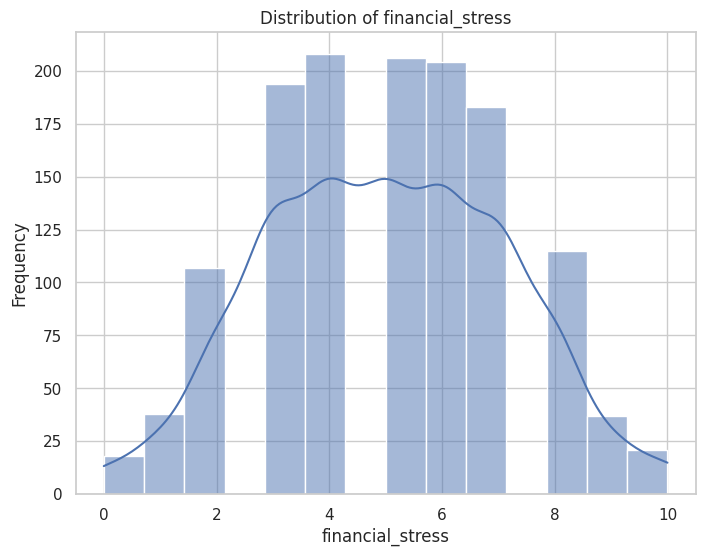

No Log Transformation


In [3]:
sns.set(style="whitegrid")

# Plots
plt.figure(figsize=(8, 6))
sns.histplot(df['stress_level_score'], kde=True)
plt.title('Distribution of Stress Level Score')
plt.xlabel('Stress Level Score')
plt.ylabel('Frequency')
plt.show()


continuous_vars = ['age', 'sleep_quality', 'daily_screen_time', 'social_interactions', 'financial_stress']

for var in continuous_vars:
    plt.figure(figsize=(8, 6))
    sns.histplot(df[var], kde=True)
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.show()

    # Checking if log transformation might be needed
    if df[var].min() > 0:
        print("Requires Log Transformation")
        plt.figure(figsize=(8, 6))
        sns.histplot(np.log(df[var]), kde=True)
        plt.title(f'Log-transformed Distribution of {var}')
        plt.xlabel(f'Log of {var}')
        plt.ylabel('Frequency')
        plt.show()
    else:
      print("No Log Transformation")

Based on the provided histograms none of the variables seem to require a log transformation.

* **Stress Level Score**: No log transformation needed because the distribution
has a long right tail, but it includes zero values which cannot be log-transformed.

* **Age**: No log transformation needed as the distribution is relatively uniform without a lot of skewness.

* **Sleep Quality**: No log transformation needed because the data is concentrated at high values and the scale is discrete.

* **Daily Screen Time**: No log transformation needed due to the multi-modal distribution without a lot of skewness.

* **Social Interactions**: No log transformation needed as it is a discrete variable with a right skew but includes zero values.

* **Financial Stress**: No log transformation needed as the distribution bell-shaped with a very slight right skew.


Problem 2. Looking ahead, we are going to using linear regression, LASSO regression, and regression trees for this data. Based on these models and by looking at the data, would you recommend standardizing the data before we build our models? Why?

Yes I recommend standardizing the data for consistency across models, especially LASSO becasue it is sensitive to the scale of input features. The standardization ensures that the penalty applied by LASSO is fair across all coefficients. While it is not necessary for the regression trees, using standardized data wil not negatively impact the tree models and allows for easier comparison across model types.

Problem 3. Split the data into a train and test set. Fit a model with all the predictors on the test set. Remove variables so only significant features remain while confirming that the model performance improves by evaluating the model on the test set.

In [4]:
X = pd.get_dummies(df.drop('stress_level_score', axis=1), drop_first=True)
y = df['stress_level_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_test)
initial_mse = mean_squared_error(y_test, predictions)

print(f'Initial MSE: {initial_mse}')

X_train_with_constant = sm.add_constant(X_train)  # Adding a constant for the intercept
full_model = sm.OLS(y_train, X_train_with_constant).fit()

print(full_model.summary())

Initial MSE: 2.2145510874775427
                            OLS Regression Results                            
Dep. Variable:     stress_level_score   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     15.23
Date:                Thu, 21 Dec 2023   Prob (F-statistic):           5.22e-34
Time:                        04:14:24   Log-Likelihood:                -1910.9
No. Observations:                1064   AIC:                             3852.
Df Residuals:                    1049   BIC:                             3926.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

In [5]:
best_mse = initial_mse
best_features = X_train.columns.tolist()

# Iteratively remove features and evaluate the model
for _ in range(len(X_train.columns)):

    X_train_with_constant = sm.add_constant(X_train[best_features])
    model = sm.OLS(y_train, X_train_with_constant).fit()

    # Identify the highest p-value
    p_values = model.pvalues.iloc[1:]  # exclude the intercept
    max_p_value_feature = p_values.idxmax()
    max_p_value = p_values.max()

    # Remove the feature if above the threshold
    if max_p_value > 0.05:
        features = best_features.copy()
        features.remove(max_p_value_feature)

        # Refit
        X_train_refit = sm.add_constant(X_train[features])
        model_refit = sm.OLS(y_train, X_train_refit).fit()

        # Evaluate
        X_test_refit = sm.add_constant(X_test[features])
        predictions_refit = model_refit.predict(X_test_refit)
        mse_refit = mean_squared_error(y_test, predictions_refit)

        # Check if improved
        if mse_refit < best_mse:
            best_mse = mse_refit
            best_features = features
        else:
            print('Performance did not improve. Process stoped\n')
            break
    else:
        print('All features significant. Process stoped\n')
        break

print("Best Features:", best_features)
print("Best MSE:", best_mse)


Performance did not improve. Process stoped

Best Features: ['age', 'sleep_quality', 'daily_screen_time', 'social_interactions', 'financial_stress', 'occupation_Retired', 'occupation_Student', 'occupation_Unemployed', 'physical_activity_Light', 'physical_activity_Moderate', 'physical_activity_Sedentary', 'diet_quality_Good', 'diet_quality_Poor']
Best MSE: 2.2036473579395226


Problem 4. From the model in Problem 3, what is the confidence interval for the regression coefficient associated with age?

In [6]:
confidence_interval_age = full_model.conf_int().loc['age']
print("Confidence Interval for 'age': \n", confidence_interval_age)

Confidence Interval for 'age': 
 0    0.002232
1    0.015723
Name: age, dtype: float64


Problem 5. Test adding age^2 and social_interaction^2 into the model. Test adding an interaction between screen time and sleep quality. Test adding an interaction between social interaction and financial stress. Determine if the higher order terms you have tested are significant or not. Remove the interactions that are not. The final model you get from this problem will be used in several other problems, so keep track of it!

In [7]:
# Create higher-order and interaction terms
X_train['age_squared'] = X_train['age'] ** 2
X_train['social_interactions_squared'] = X_train['social_interactions'] ** 2
X_train['screen_time_sleep_interaction'] = X_train['daily_screen_time'] * X_train['sleep_quality']
X_train['social_financial_interaction'] = X_train['social_interactions'] * X_train['financial_stress']

# Add to model
X_train_with_constant = sm.add_constant(X_train)
model_with_interactions = sm.OLS(y_train, X_train_with_constant).fit()

print(model_with_interactions.summary())

                            OLS Regression Results                            
Dep. Variable:     stress_level_score   R-squared:                       0.184
Model:                            OLS   Adj. R-squared:                  0.170
Method:                 Least Squares   F-statistic:                     13.13
Date:                Thu, 21 Dec 2023   Prob (F-statistic):           1.14e-35
Time:                        04:14:25   Log-Likelihood:                -1900.9
No. Observations:                1064   AIC:                             3840.
Df Residuals:                    1045   BIC:                             3934.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [8]:
# Remove non-significant higher-order and interaction terms
X_train = X_train.drop(['social_interactions_squared', 'screen_time_sleep_interaction'], axis=1)

# Refit the model
X_train_with_constant = sm.add_constant(X_train)
refit_model = sm.OLS(y_train, X_train_with_constant).fit()

print(refit_model.summary())

                            OLS Regression Results                            
Dep. Variable:     stress_level_score   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     14.66
Date:                Thu, 21 Dec 2023   Prob (F-statistic):           1.79e-36
Time:                        04:14:25   Log-Likelihood:                -1901.8
No. Observations:                1064   AIC:                             3838.
Df Residuals:                    1047   BIC:                             3922.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [9]:
model_summary = refit_model.summary2().tables[1]
non_significant_vars = model_summary[model_summary['P>|t|'] > 0.05]
print("Non-significant Variables:")
print(non_significant_vars)

Non-significant Variables:
                           Coef.  Std.Err.         t     P>|t|    [0.025  \
daily_screen_time       0.025071  0.021370  1.173166  0.240996 -0.016862   
social_interactions     0.046918  0.085249  0.550364  0.582187 -0.120360   
financial_stress        0.010356  0.046260  0.223868  0.822904 -0.080416   
occupation_Retired      0.022617  0.168136  0.134517  0.893020 -0.307305   
occupation_Student     -0.200655  0.114233 -1.756538  0.079289 -0.424807   
occupation_Unemployed  -0.138678  0.153451 -0.903727  0.366348 -0.439784   
diet_quality_Excellent -0.087009  0.131260 -0.662874  0.507557 -0.344570   
diet_quality_Good       0.194539  0.104761  1.856974  0.063595 -0.011027   
diet_quality_Poor       0.268448  0.163094  1.645974  0.100069 -0.051580   

                          0.975]  
daily_screen_time       0.067004  
social_interactions     0.214196  
financial_stress        0.101129  
occupation_Retired      0.352539  
occupation_Student      0.023497  
oc

In [10]:
# Removing candidates
X_train_reduced = X_train.drop(['financial_stress', 'occupation_Retired',
                                'occupation_Unemployed', 'diet_quality_Excellent'], axis=1)

# Refitting model
X_train_reduced_with_constant = sm.add_constant(X_train_reduced)
refit_model_reduced = sm.OLS(y_train, X_train_reduced_with_constant).fit()

print(refit_model_reduced.summary())

X_test['age_squared'] = X_test['age'] ** 2
X_test['social_financial_interaction'] = X_test['social_interactions'] * X_test['financial_stress']
X_test_reduced = X_test[X_train_reduced.columns]
X_test_reduced_with_constant = sm.add_constant(X_test_reduced)

predictions_reduced = refit_model_reduced.predict(X_test_reduced_with_constant)

mse_reduced = mean_squared_error(y_test, predictions_reduced)

print(f'Reduced Model MSE: {mse_reduced}')

                            OLS Regression Results                            
Dep. Variable:     stress_level_score   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     19.49
Date:                Thu, 21 Dec 2023   Prob (F-statistic):           9.80e-39
Time:                        04:14:25   Log-Likelihood:                -1902.5
No. Observations:                1064   AIC:                             3831.
Df Residuals:                    1051   BIC:                             3896.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [11]:
X_train_reduced_with_constant = sm.add_constant(X_train_reduced)

# Calculating VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train_reduced_with_constant.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_reduced_with_constant.values, i) for i in range(X_train_reduced_with_constant.shape[1])]

print(vif_data)

                         Feature         VIF
0                          const  159.832994
1                            age   44.688821
2                  sleep_quality    1.038623
3              daily_screen_time    1.004250
4            social_interactions    3.390399
5             occupation_Student    1.011060
6        physical_activity_Light    2.948757
7     physical_activity_Moderate    2.373769
8    physical_activity_Sedentary    3.013218
9              diet_quality_Good    1.069693
10             diet_quality_Poor    1.076697
11                   age_squared   44.301641
12  social_financial_interaction    3.012752


I added 'age^2', 'social_interactions^2', 'interaction between screen time and sleep quality', and 'interaction between social interactions and financial stress' to the model. After assessing their significance, 'age^2' and the 'interaction between social interactions and financial stress' were found to be significant. I removed nonsignificant higher order terms and interactions, creating a refined model for further analysis.

Problem 6. Start again using data with all the predictors and with all higher order terms listed in problem 5 (meaning even if your previous models removed variables, add them all back in). Perform a LASSO regression model. Tune the model to find a good LASSO parameter.

In [12]:
#Prepare the Data
df['age_squared'] = df['age'] ** 2
df['social_interactions_squared'] = df['social_interactions'] ** 2
df['screen_time_sleep_interaction'] = df['daily_screen_time'] * df['sleep_quality']
df['social_financial_interaction'] = df['social_interactions'] * df['financial_stress']

#the dummies
X = pd.get_dummies(df.drop('stress_level_score', axis=1), drop_first=True)
y = df['stress_level_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#LASSO
lasso_cv = LassoCV(cv=5, random_state=42)
lasso_cv.fit(X_train_scaled, y_train)

optimal_alpha = lasso_cv.alpha_
print(f'Optimal LASSO Parameter (Alpha): {optimal_alpha}')

lasso_pred = lasso_cv.predict(X_test_scaled)
lasso_mse = mean_squared_error(y_test, lasso_pred)
print(f'LASSO Regression MSE: {lasso_mse}')

Optimal LASSO Parameter (Alpha): 0.0033430623349501422
LASSO Regression MSE: 2.1690722522894483


In [13]:
# Extracting the coefficients and exploring coefficients for tunning model
lasso_coefficients = lasso_cv.coef_

feature_names = X.columns
lasso_coeff_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': lasso_coefficients})

zero_coeff_features = lasso_coeff_df[lasso_coeff_df['Coefficient'] == 0]
non_zero_coeff_features = lasso_coeff_df[lasso_coeff_df['Coefficient'] != 0]

print("Coefficients Shrunk to Zero:")
print(zero_coeff_features)
print("\nNon-Zero Coefficients:")
print(non_zero_coeff_features)


Coefficients Shrunk to Zero:
Empty DataFrame
Columns: [Feature, Coefficient]
Index: []

Non-Zero Coefficients:
                          Feature  Coefficient
0                             age     0.776055
1                   sleep_quality    -0.250417
2               daily_screen_time     0.050974
3             social_interactions     0.161282
4                financial_stress    -0.009340
5                     age_squared    -0.643076
6     social_interactions_squared    -0.149792
7   screen_time_sleep_interaction     0.001453
8    social_financial_interaction    -0.324080
9              occupation_Retired     0.000673
10             occupation_Student    -0.079308
11          occupation_Unemployed    -0.043442
12        physical_activity_Light     0.299606
13     physical_activity_Moderate     0.230659
14    physical_activity_Sedentary     0.566174
15         diet_quality_Excellent    -0.029999
16              diet_quality_Good     0.090037
17              diet_quality_Poor     0.072

Problem 7. Build a regression tree for the data. Use cost complexity pruning to determine a good tree to use. For this, use all original variables but no higher order terms.

In [14]:
print(df.columns)

Index(['age', 'occupation', 'physical_activity', 'sleep_quality',
       'daily_screen_time', 'social_interactions', 'financial_stress',
       'diet_quality', 'stress_level_score', 'age_squared',
       'social_interactions_squared', 'screen_time_sleep_interaction',
       'social_financial_interaction'],
      dtype='object')


In [15]:
X = pd.get_dummies(df[['age', 'physical_activity', 'sleep_quality',
                       'daily_screen_time', 'social_interactions',
                       'financial_stress', 'occupation', 'diet_quality']],
                   drop_first=True)
y = df['stress_level_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Regression Tree
param_grid = {'ccp_alpha': np.linspace(0, 0.01, 100)}
tree_regressor = DecisionTreeRegressor(random_state=42)
grid_search = GridSearchCV(tree_regressor, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

optimal_ccp_alpha = grid_search.best_params_['ccp_alpha']
print(f'Optimal ccp_alpha: {optimal_ccp_alpha}')

pruned_tree = DecisionTreeRegressor(random_state=42, ccp_alpha=optimal_ccp_alpha)
pruned_tree.fit(X_train, y_train)
pruned_tree_pred = pruned_tree.predict(X_test)
pruned_tree_mse = mean_squared_error(y_test, pruned_tree_pred)
print(f'Pruned Tree MSE: {pruned_tree_mse}')

Optimal ccp_alpha: 0.01
Pruned Tree MSE: 2.6964033235849807


Problem 8. You have built three tuned models, the linear regression model with potential higher order terms, a LASSO regression model, and a regression tree. Use out of sample MSE to determine which model is the best.

In [16]:
# Re-assigning variables so I don't get lost and make mistakes in further analysis
linear_mse = mse_reduced
lasso_mse = lasso_mse
pruned_tree_mse = pruned_tree_mse

print(f'Linear Regression MSE: {linear_mse}')
print(f'LASSO Regression MSE: {lasso_mse}')
print(f'Pruned Tree MSE: {pruned_tree_mse}')

# Best model check
best_model_mse = min(linear_mse, lasso_mse, pruned_tree_mse)
if best_model_mse == linear_mse:
    print("Best Model: Linear Regression with Reduced Features")
elif best_model_mse == lasso_mse:
    print("Best Model: LASSO Regression")
else:
    print("Best Model: Pruned Regression Tree")


Linear Regression MSE: 2.133048077932711
LASSO Regression MSE: 2.1690722522894483
Pruned Tree MSE: 2.6964033235849807
Best Model: Linear Regression with Reduced Features


According to the analisys the best model is the 'Linear Regression with Reduced Features.

Problem 9. Use feature importances for the regression tree model, p values for the linear regression model, and the coefficients from the LASSO model, state three predictors you find to be important for predicting stress. State three variables you  find to be either not important for predicting stress, or at least not as important as other predictors. Justify your reasoning by refering to specific output from the models.

In [17]:
# Regression Tree
feature_importances = pruned_tree.feature_importances_
tree_features = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
print(tree_features.sort_values(by='Importance', ascending=False))

                        Feature  Importance
0                           age    0.217968
7   physical_activity_Sedentary    0.161995
3           social_interactions    0.156422
1                 sleep_quality    0.142591
4              financial_stress    0.139659
2             daily_screen_time    0.068486
5       physical_activity_Light    0.032024
13            diet_quality_Poor    0.026038
8            occupation_Retired    0.021069
6    physical_activity_Moderate    0.013030
11       diet_quality_Excellent    0.012761
12            diet_quality_Good    0.007958
9            occupation_Student    0.000000
10        occupation_Unemployed    0.000000


In [18]:
# p-values from Linear Regression Model
linear_pvalues = refit_model_reduced.pvalues
linear_features = pd.DataFrame({'Feature': X_train_reduced_with_constant.columns, 'p-value': linear_pvalues})
print(linear_features.sort_values(by='p-value'))

                                                   Feature       p-value
physical_activity_Sedentary    physical_activity_Sedentary  7.584481e-14
sleep_quality                                sleep_quality  4.394794e-08
social_financial_interaction  social_financial_interaction  6.372755e-07
physical_activity_Light            physical_activity_Light  2.761001e-05
age                                                    age  1.731062e-04
physical_activity_Moderate      physical_activity_Moderate  2.657555e-04
age_squared                                    age_squared  8.899680e-04
const                                                const  1.570265e-02
diet_quality_Good                        diet_quality_Good  2.198031e-02
diet_quality_Poor                        diet_quality_Poor  6.053943e-02
occupation_Student                      occupation_Student  9.344440e-02
daily_screen_time                        daily_screen_time  2.302932e-01
social_interactions                    social_inter

In [19]:
# Coefficients from LASSO Model
print(lasso_coeff_df.sort_values(by='Coefficient', ascending=False))

                          Feature  Coefficient
0                             age     0.776055
14    physical_activity_Sedentary     0.566174
12        physical_activity_Light     0.299606
13     physical_activity_Moderate     0.230659
3             social_interactions     0.161282
16              diet_quality_Good     0.090037
17              diet_quality_Poor     0.072938
2               daily_screen_time     0.050974
7   screen_time_sleep_interaction     0.001453
9              occupation_Retired     0.000673
4                financial_stress    -0.009340
15         diet_quality_Excellent    -0.029999
11          occupation_Unemployed    -0.043442
10             occupation_Student    -0.079308
6     social_interactions_squared    -0.149792
1                   sleep_quality    -0.250417
8    social_financial_interaction    -0.324080
5                     age_squared    -0.643076


In [20]:
print("\nTop 3 Important Predictors from Each Model:")
print(tree_features.sort_values(by='Importance', ascending=False).head(3))
print(linear_features.sort_values(by='p-value').head(3))
print(lasso_coeff_df.sort_values(by='Coefficient', ascending=False).head(3))

print("\nTop 3 Less Important Predictors from Each Model:")
print(tree_features.sort_values(by='Importance').head(3))
print(linear_features.sort_values(by='p-value', ascending=False).head(3))
print(lasso_coeff_df.sort_values(by='Coefficient').head(3))


Top 3 Important Predictors from Each Model:
                       Feature  Importance
0                          age    0.217968
7  physical_activity_Sedentary    0.161995
3          social_interactions    0.156422
                                                   Feature       p-value
physical_activity_Sedentary    physical_activity_Sedentary  7.584481e-14
sleep_quality                                sleep_quality  4.394794e-08
social_financial_interaction  social_financial_interaction  6.372755e-07
                        Feature  Coefficient
0                           age     0.776055
14  physical_activity_Sedentary     0.566174
12      physical_activity_Light     0.299606

Top 3 Less Important Predictors from Each Model:
                  Feature  Importance
9      occupation_Student    0.000000
10  occupation_Unemployed    0.000000
12      diet_quality_Good    0.007958
                                 Feature   p-value
social_interactions  social_interactions  0.364880
daily_s

The importance of predictors is inferred from their low p-values in the linear regression model, the magnitude and direction of coefficients in the LASSO model, and feature importance in the regression tree.

Less important predictors are identified based on lower coefficients, higher p-values, and lower feature importance. These insights collectively offer a comprehensive view of the factors influencing stress levels.

Problem 10. You recieve a new data point. The new data point can be found at

https://richardson.byu.edu/220/stress_new.csv

Using the final linear regression from problem 5, predict what this individual's stress level will be.

In [21]:
new_df = pd.read_csv('https://richardson.byu.edu/220/stress.csv')

first_row = new_df.iloc[0].copy()
first_row['age_squared'] = first_row['age'] ** 2
first_row['social_financial_interaction'] = first_row['social_interactions'] * first_row['financial_stress']

categorical_vars = ['occupation', 'physical_activity', 'diet_quality']
first_row_prepared = pd.get_dummies(pd.DataFrame([first_row]), columns=categorical_vars, drop_first=True)

# from Problem 5
final_features = ['age', 'sleep_quality', 'daily_screen_time',
                  'social_interactions', 'financial_stress', 'age_squared',
                  'social_financial_interaction', 'physical_activity_Light',
                  'physical_activity_Moderate', 'physical_activity_Sedentary',
                  'diet_quality_Good', 'diet_quality_Poor']

for column in final_features:
    if column not in first_row_prepared.columns:
        first_row_prepared[column] = 0

first_row_final = first_row_prepared[final_features]
first_row_final_with_constant = sm.add_constant(first_row_final, has_constant='add')

predicted_stress = refit_model_reduced.predict(first_row_final_with_constant)
print(predicted_stress)

0    2882.405702
dtype: float64


Problem 11. For the new individual introduced in problem 11, find a prediction interval for the stress level.

In [22]:
predicted_stress = 2882.405702

df = len(X_train_reduced) - len(refit_model_reduced.params)

std_err = refit_model_reduced.bse

t_critical = stats.t.ppf(0.975, df)

margin_error = t_critical * std_err

lower_bound = predicted_stress - margin_error
upper_bound = predicted_stress + margin_error

prediction_interval = {
    "Lower Bound": lower_bound,
    "Upper Bound": upper_bound
}

print(prediction_interval)

{'Lower Bound': const                           2881.298893
age                             2882.367026
sleep_quality                   2882.341016
daily_screen_time               2882.363835
social_interactions             2882.301336
occupation_Student              2882.192844
physical_activity_Light         2882.088818
physical_activity_Moderate      2882.059790
physical_activity_Sedentary     2882.090827
diet_quality_Good               2882.216952
diet_quality_Poor               2882.097142
age_squared                     2882.405271
social_financial_interaction    2882.391057
dtype: float64, 'Upper Bound': const                           2883.512511
age                             2882.444378
sleep_quality                   2882.470388
daily_screen_time               2882.447569
social_interactions             2882.510068
occupation_Student              2882.618560
physical_activity_Light         2882.722586
physical_activity_Moderate      2882.751614
physical_activity_Sedentary  

In [23]:
params = refit_model_reduced.params
cov_matrix = refit_model_reduced.cov_params()

# variance
var_prediction = np.dot(np.dot(first_row_final_with_constant, cov_matrix), first_row_final_with_constant.T)

se_prediction = np.sqrt(var_prediction)

# Degrees of freedom
df = len(X_train_reduced) - len(params)

t_critical = stats.t.ppf(0.975, df)

# Prediction from Problem 10
predicted_stress_value = 2882.405702

margin_error = t_critical * se_prediction

lower_bound = predicted_stress_value - margin_error
upper_bound = predicted_stress_value + margin_error

prediction_interval = {
    "Lower Bound": lower_bound.item(),
    "Upper Bound": upper_bound.item()
}

print(prediction_interval)

{'Lower Bound': 1541.8036197410936, 'Upper Bound': 4223.007784258906}


Problem 12. Use all the variables from the original model and add all 4 higher order terms from problem 5. Build a Bayesian linear regression model. Standardize the data and use N(0,1) priors for the variables.

In [24]:
#Restarting the enviroment and execute cells againg maight be needed
import os
os.environ["THEANO_FLAGS"] = "blas__ldflags="
!pip install pymc3
import pymc3 as pm

In [25]:
#Error handling
if isinstance(new_df, pd.DataFrame):
    # Add higher terms
    new_df['age_squared'] = new_df['age'] ** 2
    new_df['social_interactions_squared'] = new_df['social_interactions'] ** 2
    new_df['screen_time_sleep_interaction'] = new_df['daily_screen_time'] * new_df['sleep_quality']
    new_df['social_financial_interaction'] = new_df['social_interactions'] * new_df['financial_stress']

    # Standardize the data
    scaler = StandardScaler()
    X = pd.get_dummies(new_df.drop('stress_level_score', axis=1), drop_first=True)
    X_standardized = scaler.fit_transform(X)
    y = new_df['stress_level_score']

    # Bayesian model
    with pm.Model() as bayesian_model:
        priors = {var: pm.Normal(var, mu=0, sigma=1) for var in X.columns}
        mu = pm.Deterministic('mu', pm.math.dot(X_standardized, pm.math.stack(list(priors.values()))))
        sigma = pm.HalfNormal('sigma', sigma=1)
        y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)
        trace = pm.sample(1000, return_inferencedata=True)
else:
    print("Error: new_df is not a DataFrame. Check the dataset loading process.") # Debug

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:187: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


In [26]:
pm_summary = pm.summary(trace)
print(pm_summary)

                      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
age                  0.899  0.402   0.204    1.695      0.009    0.007   
sleep_quality       -0.312  0.126  -0.545   -0.081      0.003    0.002   
daily_screen_time   -0.062  0.248  -0.538    0.365      0.006    0.006   
social_interactions  0.129  0.264  -0.391    0.578      0.006    0.006   
financial_stress     0.044  0.142  -0.221    0.309      0.004    0.003   
...                    ...    ...     ...      ...        ...      ...   
mu[1327]             1.096  0.479   0.263    2.083      0.011    0.008   
mu[1328]            -0.711  0.296  -1.211   -0.128      0.006    0.004   
mu[1329]            -0.535  0.301  -1.122    0.002      0.007    0.005   
mu[1330]             0.321  0.210  -0.105    0.687      0.004    0.003   
sigma                2.488  0.047   2.405    2.579      0.001    0.001   

                     ess_bulk  ess_tail  r_hat  
age                    2112.0    1282.0    1.0  
sleep_quality

**Part 2** A successful video game streamer is defined as someone who has over 1,000 subscribers to their platform. A data set of several video game streamers who log at least 5 hours a week can be found at

https://richardson.byu.edu/220/game_stream.csv

The target variable is "success" and is either 1 or 0. The other variables are predictor varibales and include streaming hours, genre, interaction level, equipment quality, and social media presence.

First of all, a moment of silence for a whopping 47 streamers with more than 30 hours a week and less than 1,000 subscribers. Then get on with the rest of the problems!

In [27]:
url = 'https://richardson.byu.edu/220/game_stream.csv'
df = pd.read_csv(url)
print(df.columns)

Index(['streaming_hours', 'game_genre', 'interaction_level',
       'equipment_quality', 'social_media_presence', 'years_experience',
       'success'],
      dtype='object')


Problem 13. Split the data into a training and test set. Fit a logistic regression model to the training set.

In [28]:
X = df.drop('success', axis=1)
y = df['success']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

categorical_vars = ['game_genre', 'interaction_level', 'equipment_quality', 'social_media_presence']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_vars)
    ],
    remainder='passthrough'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['game_genre',
                                                   'interaction_level',
                                                   'equipment_quality',
                                                   'social_media_presence'])])),
                ('classifier', LogisticRegression(max_iter=1000))])

Problem 14. Fit a classification tree to the training set.

In [29]:
X = df.drop('success', axis=1)
y = df['success']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_prepared = preprocessor.fit_transform(X_train)

tree_classifier = DecisionTreeClassifier(random_state=42)
tree_classifier.fit(X_train_prepared, y_train)

DecisionTreeClassifier(random_state=42)

Problem 15. Use out of sample accuracy to determine which model fits better.

In [30]:
X_test_prepared = preprocessor.transform(X_test)

logistic_predictions = pipeline.predict(X_test)

tree_predictions = tree_classifier.predict(X_test_prepared)

logistic_accuracy = accuracy_score(y_test, logistic_predictions)
tree_accuracy = accuracy_score(y_test, tree_predictions)


print(f"Logistic Regression accuracy: {logistic_accuracy}")
print(f"Decision Tree accuracy: {tree_accuracy}")

if logistic_accuracy > tree_accuracy:
    print("Logistic Regression model fits better.")
elif logistic_accuracy < tree_accuracy:
    print("Decision Tree model fits better.")
else:
    print("Both models have the same accuracy.")

Logistic Regression accuracy: 0.91
Decision Tree accuracy: 0.89
Logistic Regression model fits better.
